# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Feature engineering
4. Modelling
5. Evaluation

---

## 1. Import packages

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
# Import packages to calculate performance of the models

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score

#Class Balancing Techniques
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

---
## 2. Load data

In [5]:
df = pd.read_csv('data/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [6]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with predictive power.

In [7]:
price_df = pd.read_csv('data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [8]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [9]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


---

## Average price changes across periods

We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [10]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [11]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [12]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


This feature may be useful because it adds more granularity to the existing feature that my colleague found to be useful. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

---

## Max price changes across periods and months

Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [13]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [14]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [15]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [16]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


I thought that calculating the maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.

In [17]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


### Transforming Boolean data

#### has_gas

We simply want to transform this column from being categorical to being a binary flag

In [18]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

### Transforming categorical data

A predictive model cannot accept categorical or `string` values, hence as a data scientist you need to encode categorical features into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present `0 < 1 < 2 < 3 ...`

Another way to encode categorical features is to use `dummy variables` AKA `one hot encoding`. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

#### channel_sales

In [19]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [20]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel',dtype=int)
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,0.085483,0.146033,44.266930,8.145775,44.26693,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0.085483,0.151367,44.444710,0.000000,44.44471,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,0.089162,0.172468,44.444710,0.000000,44.44471,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0.000000,0.153133,44.444710,0.000000,44.44471,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,0.033743,0.055866,16.291555,8.145775,24.43733,1,0,0,0,0


#### origin_up

In [21]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

Similar to `channel_sales` the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [22]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up',dtype=int)
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,8.145775,44.26693,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0.000000,44.44471,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,0.000000,44.44471,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0.000000,44.44471,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,8.145775,24.43733,1,0,0,0,0,1,0,0


### Transforming numerical data

In the previous eda we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called `parametric` models, and they typically assume that all variables are both independent and normally distributed. 

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root
- Cubic root
- Logarithm

to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features. 

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

In [23]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [24]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [25]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

/tmp/ipykernel_14804/3336105285.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
/home/adarsh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_14804/3336105285.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-

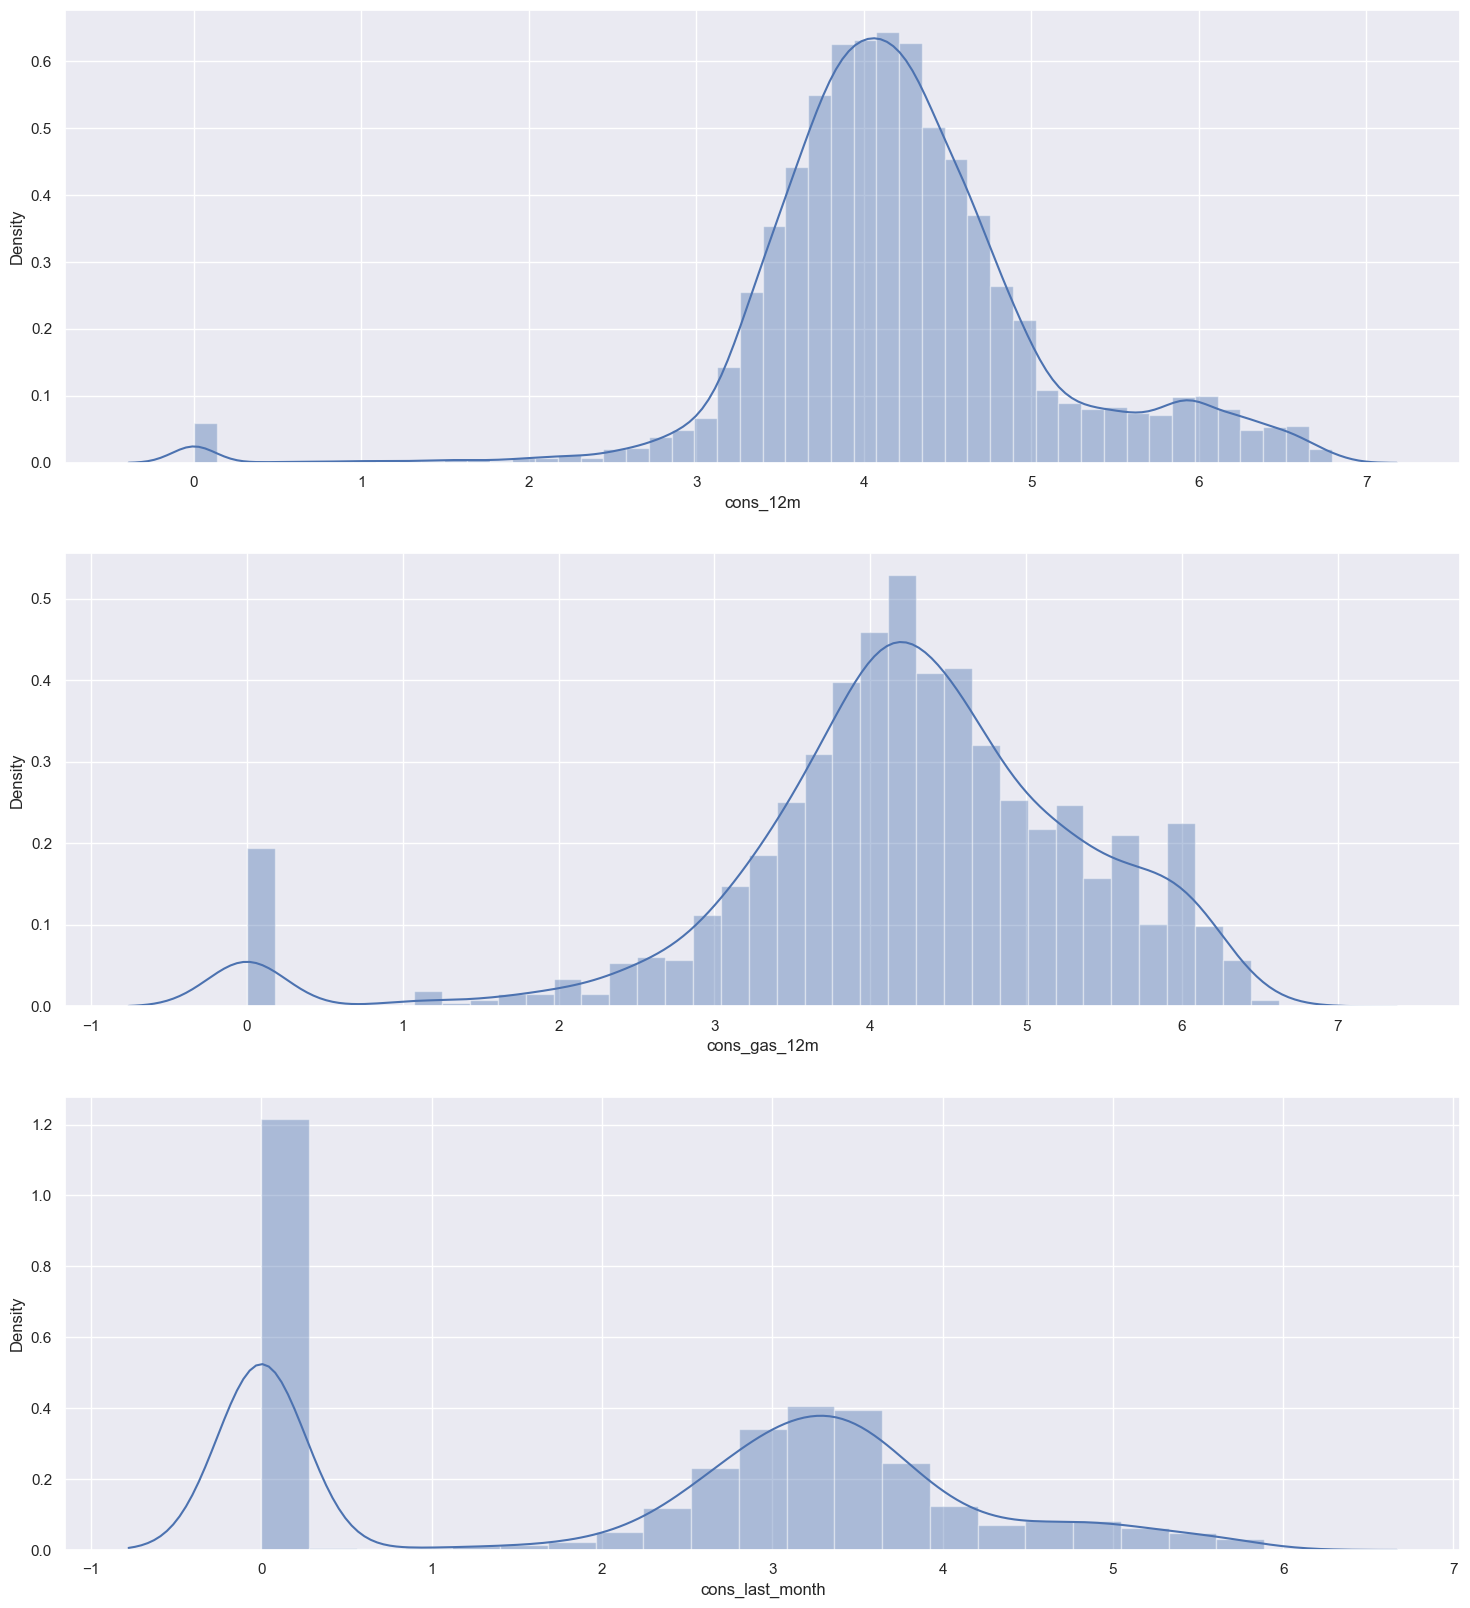

In [35]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

### Correlations

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model. 

So now let's look at how all the features within the model are correlated.

In [26]:
print(df.info())

# Check if any column has object dtype which might store the string you saw
for col in df.columns:
    if df[col].dtype == object:
        print(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 60 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_cons_year                          14606 non-null  float64
 6   forecast_discount_energy                    14606 non-null  float64
 7   forecast_meter_rent_12m                     14606 non-null  float64
 8   forecast_price_energy_off_peak              14606 non-null  float64
 9   forecast_price_energy_peak                  14606 non-null  float64
 10  forecast_p

In [27]:
columns_to_exclude = ['id']
df_numeric = df.drop(columns=columns_to_exclude)

# Calculate correlation matrix
correlation = df_numeric.corr()


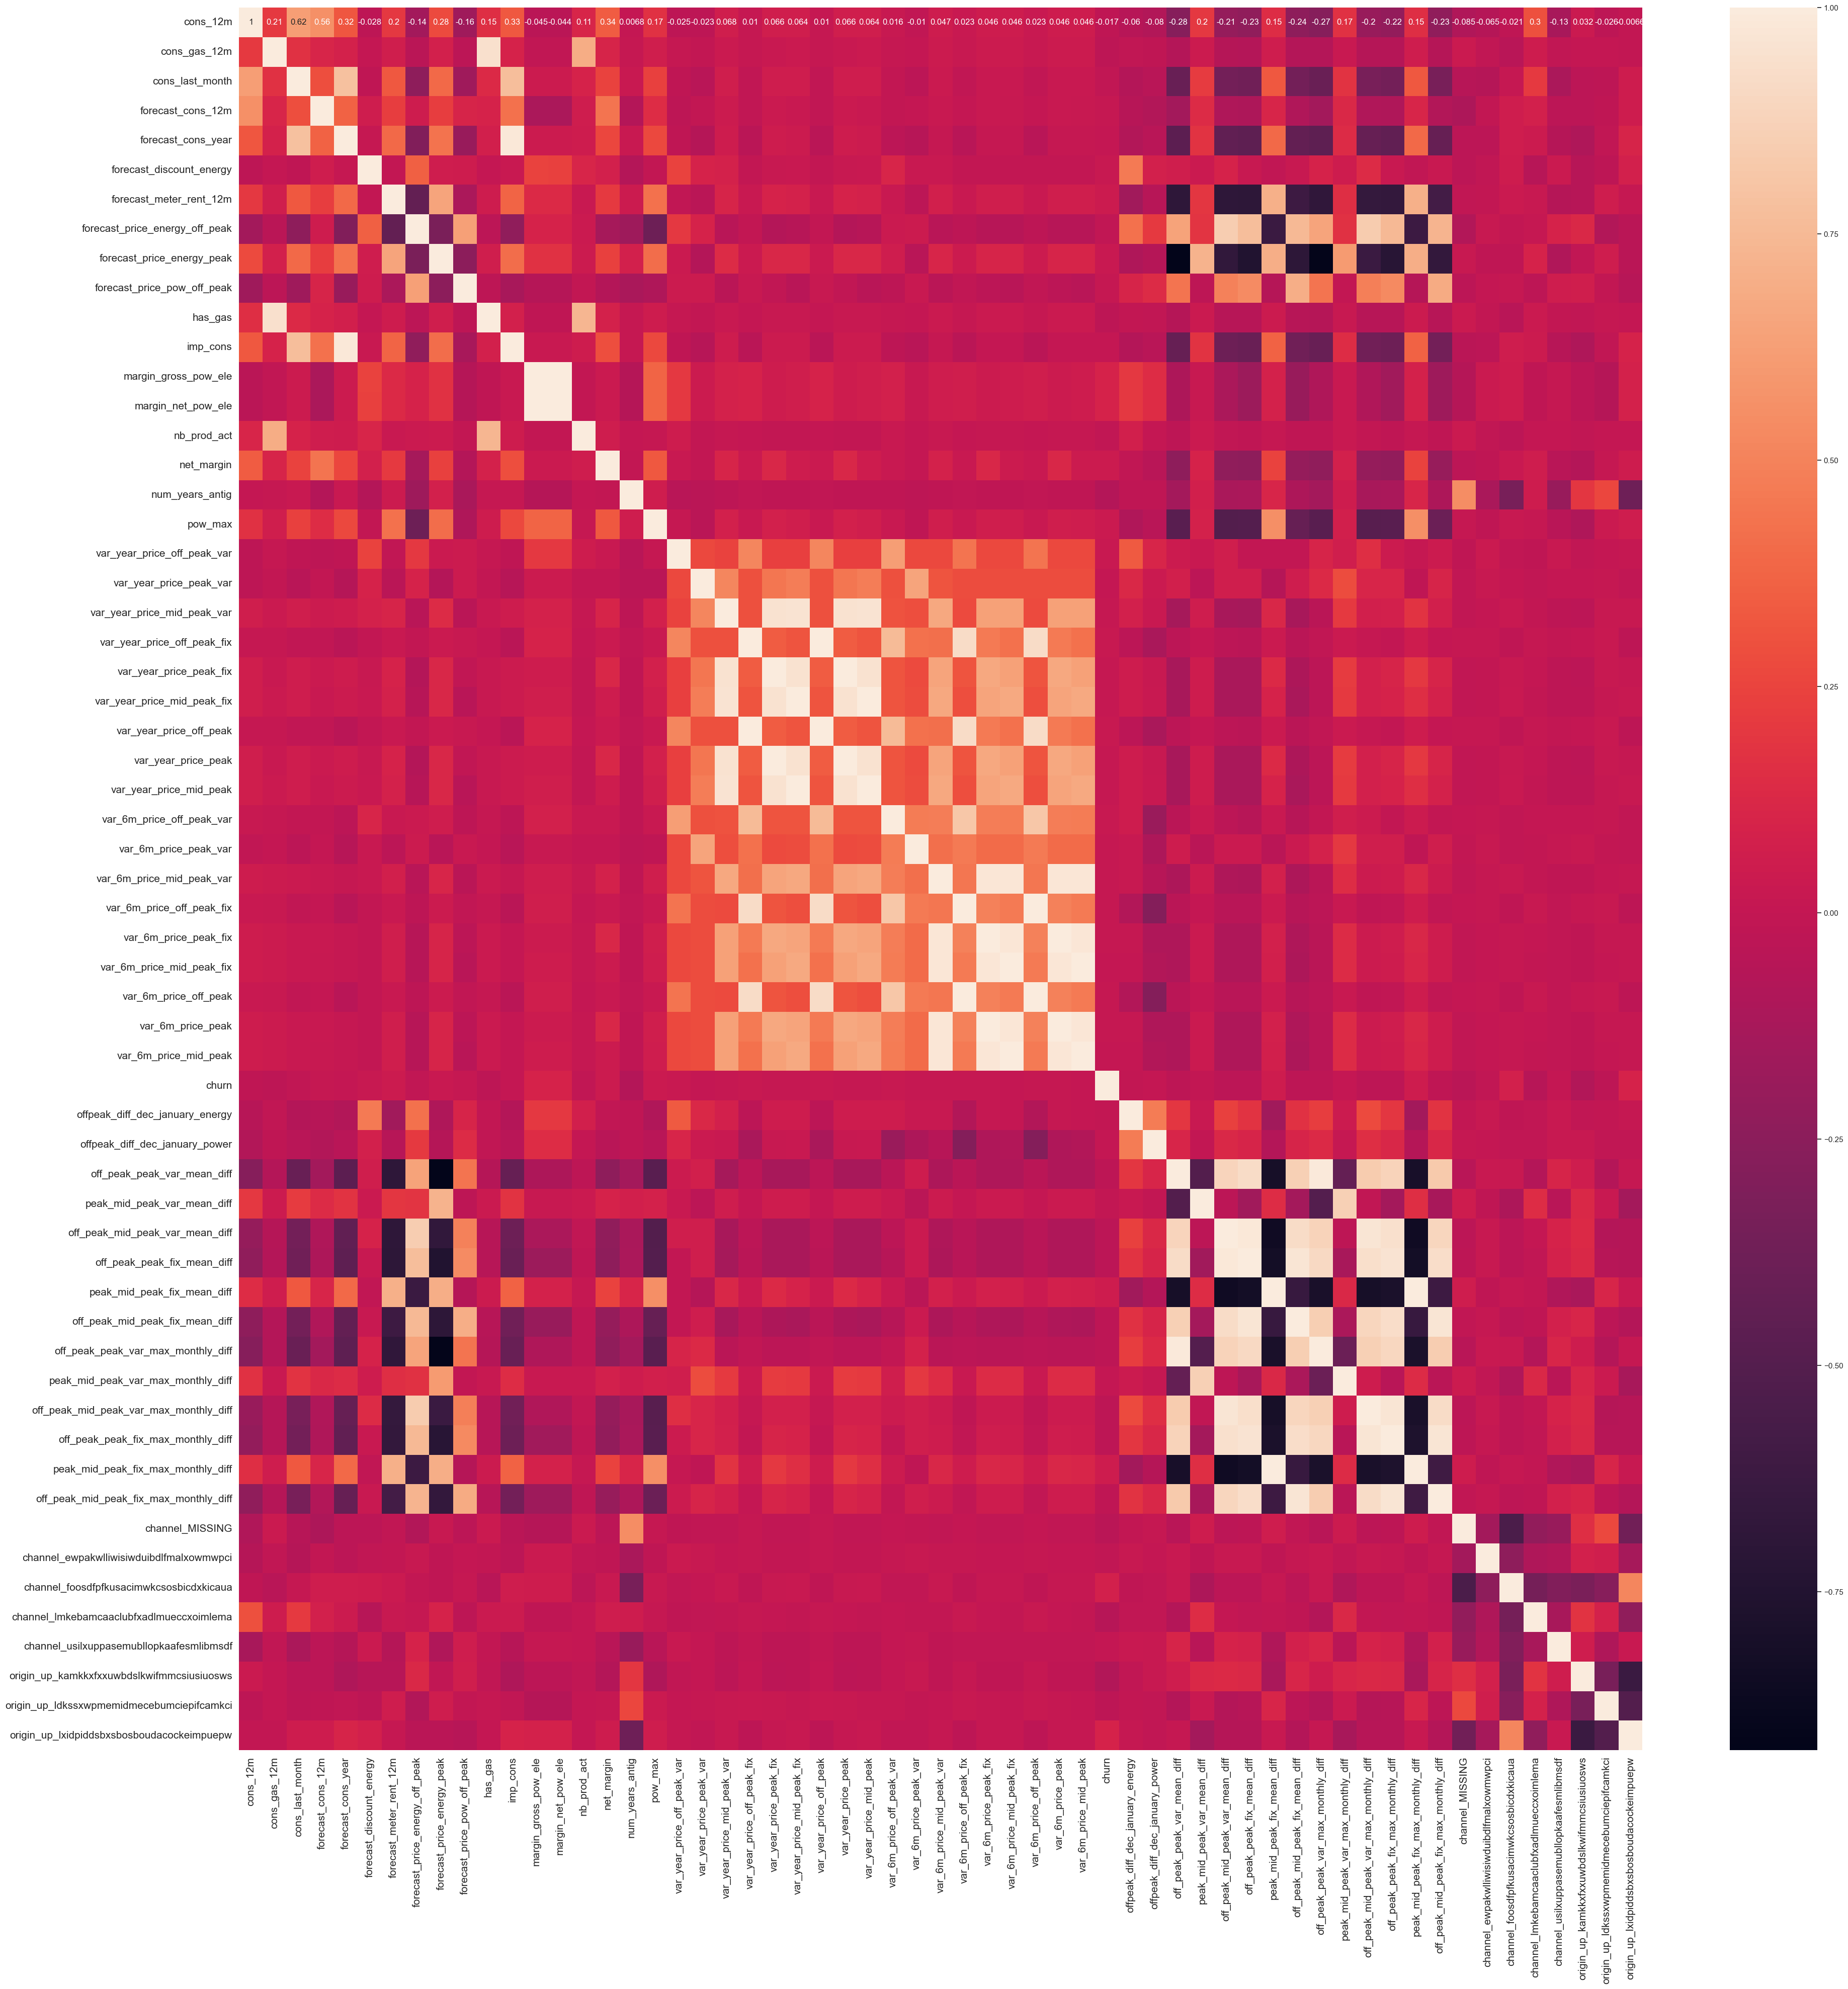

In [84]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('correlation_heatmap.png')
plt.show()

For now, I will remove two variables which exhibit a high correlation with other independent features.

In [28]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,8.145775,44.266930,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,0.000000,44.444710,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,0.000000,44.444710,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,0.000000,44.444710,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,8.145775,24.437330,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,4.508812,4.680707,0.000000,3.667360,0.0,1.291591,0.138305,0.000000,44.311378,...,0.000000,44.444710,0,0,1,0,0,0,0,1
14602,d0a6f71671571ed83b2645d23af6de00,3.858778,0.000000,2.260071,2.801191,0.0,2.161458,0.100167,0.091892,58.995952,...,28.122958,50.805737,0,0,1,0,0,0,0,1
14603,10e6828ddd62cbcf687cb74928c4c2d2,3.265996,0.000000,2.255273,2.281919,0.0,2.115943,0.116900,0.100015,40.606701,...,8.145775,24.437330,0,0,1,0,0,0,0,1
14604,1cf20fd6206d7678d5bcafd28c53b4db,2.120574,0.000000,0.000000,1.308351,0.0,0.912753,0.145711,0.000000,44.311378,...,0.000000,44.444710,0,0,1,0,0,0,0,1


In [29]:
df.isnull().sum()

id                                            0
cons_12m                                      0
cons_gas_12m                                  0
cons_last_month                               0
forecast_cons_12m                             0
forecast_discount_energy                      0
forecast_meter_rent_12m                       0
forecast_price_energy_off_peak                0
forecast_price_energy_peak                    0
forecast_price_pow_off_peak                   0
has_gas                                       0
imp_cons                                      0
margin_gross_pow_ele                          0
margin_net_pow_ele                            0
nb_prod_act                                   0
net_margin                                    0
pow_max                                       0
var_year_price_off_peak_var                   0
var_year_price_peak_var                       0
var_year_price_mid_peak_var                   0
var_year_price_off_peak_fix             

---

## 4.Modelling

1) `Random Forest` classifier.

In [30]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [31]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 56)
(14606,)


In [33]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X, y)

In [34]:
X_resampled

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
9074,4.283731,0.0000,0.000000,3.451547,0.0,1.264818,0.142819,0.000000,44.311378,0,...,0.000000,44.444710,0,0,0,1,0,0,1,0
9445,3.407391,3.5738,0.000000,2.568601,0.0,1.209515,0.138310,0.000000,44.311378,1,...,0.000000,44.444710,1,0,0,0,0,0,0,1
2926,3.731589,0.0000,0.000000,2.908999,0.0,1.251638,0.146694,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
1827,4.295655,0.0000,0.000000,3.463382,0.0,0.000000,0.142819,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
3584,3.867644,0.0000,0.000000,2.484784,0.0,1.262688,0.146694,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,3.304059,0.0000,0.000000,2.485082,0.0,1.210853,0.147506,0.000000,46.305378,0,...,0.000000,46.444710,0,0,1,0,0,0,0,1
14588,3.723209,0.0000,0.000000,2.906976,0.0,1.262214,0.144963,0.000000,44.311378,0,...,0.000000,44.444710,0,0,0,0,1,1,0,0
14593,3.592177,0.0000,2.193125,2.516099,0.0,1.239800,0.141434,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
14602,3.858778,0.0000,2.260071,2.801191,0.0,2.161458,0.100167,0.091892,58.995952,0,...,28.122958,50.805737,0,0,1,0,0,0,0,1


In [36]:
y_resampled

9074     0
9445     0
2926     0
1827     0
3584     0
        ..
14587    1
14588    1
14593    1
14602    1
14603    1
Name: churn, Length: 2838, dtype: int64

In [37]:

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [38]:
X_train_resampled

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
4319,4.973866,0.000000,3.605844,2.966372,0.0,2.120607,0.116900,0.100015,40.606701,0,...,8.145775,24.437330,0,0,1,0,0,0,0,1
687,4.328930,0.000000,0.000000,3.328035,0.0,0.000000,0.165025,0.086393,44.311378,0,...,0.000000,44.266931,0,0,0,1,0,1,0,0
14147,4.286995,0.000000,0.000000,2.846319,0.0,2.086822,0.112468,0.097351,40.606701,0,...,8.145775,24.437330,0,0,0,0,1,1,0,0
11497,4.996569,0.000000,3.590730,4.182755,0.0,1.827563,0.145711,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
4947,4.173390,4.193598,3.165541,3.168368,0.0,2.073828,0.114667,0.099548,40.606701,1,...,8.145775,24.437330,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,3.787248,0.000000,2.641474,2.962724,0.0,1.219060,0.145711,0.000000,44.311378,0,...,0.000000,44.444710,0,0,1,0,0,0,0,1
1825,3.716504,0.000000,0.000000,2.895284,0.0,0.989895,0.147506,0.000000,45.308378,0,...,0.000000,45.444710,0,0,1,0,0,0,0,1
9978,4.850033,0.000000,3.782831,3.853243,0.0,2.126489,0.113323,0.096984,40.606701,0,...,8.145775,24.437330,1,0,0,0,0,0,1,0
10471,4.063934,0.000000,2.694605,3.084215,0.0,2.111565,0.116340,0.099998,40.606701,0,...,8.145775,24.437330,0,0,1,0,0,0,0,1


In [39]:
X_test_resampled

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
5875,4.156489,0.00000,3.546419,3.154004,0.0,2.113977,0.116900,0.100015,40.606701,0,...,8.145775,24.43733,0,0,1,0,0,0,0,1
13063,4.786219,0.00000,3.784261,3.768926,0.0,2.167583,0.114481,0.098142,40.606701,0,...,8.145775,24.43733,0,0,0,0,1,0,0,1
13874,3.819676,0.00000,0.000000,2.997146,0.0,1.314499,0.145711,0.000000,44.311378,0,...,0.000000,44.44471,0,0,1,0,0,0,0,1
8918,3.729570,0.00000,3.191730,3.015268,0.0,0.000000,0.245347,0.168092,53.284378,0,...,0.000000,53.44471,0,0,1,0,0,0,0,1
5534,3.657056,0.00000,0.000000,2.688687,0.0,2.087000,0.114782,0.099665,40.939027,0,...,8.145775,24.43733,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9332,3.389698,0.00000,0.000000,2.566673,0.0,0.000000,0.145711,0.000000,44.311378,0,...,0.000000,44.44471,0,0,1,0,0,0,0,1
4563,3.831806,0.00000,2.919601,2.836950,0.0,2.121822,0.115237,0.100123,40.939027,0,...,8.113195,24.33959,1,0,0,0,0,1,0,0
8869,3.587149,4.22016,2.507856,2.761131,0.0,1.257679,0.144902,0.000000,44.311378,1,...,0.000000,44.44471,0,0,1,0,0,0,1,0
3483,4.730944,0.00000,0.000000,2.475628,0.0,1.279211,0.143460,0.000000,46.305378,0,...,0.000000,46.44471,0,0,1,0,0,0,0,1


In [41]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

In [42]:
gbc.fit(X_train_resampled, y_train_resampled)


GradientBoostingClassifier(max_depth=5)

In [43]:
y_pred = gbc.predict(X_test_resampled)

In [44]:
conf_matrix=confusion_matrix(y_test_resampled,y_pred)
conf_matrix

array([[178, 106],
       [ 99, 185]])

In [45]:
result = classification_report(y_test_resampled, y_pred)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.64      0.63      0.63       284
           1       0.64      0.65      0.64       284

    accuracy                           0.64       568
   macro avg       0.64      0.64      0.64       568
weighted avg       0.64      0.64      0.64       568



In [46]:
print(f"Accuracy: {metrics.accuracy_score(y_test_resampled, y_pred)}")
print(f"Precision: {metrics.precision_score(y_test_resampled, y_pred)}")
print(f"Recall: {metrics.recall_score(y_test_resampled, y_pred)}")

Accuracy: 0.6390845070422535
Precision: 0.6357388316151202
Recall: 0.6514084507042254


In [58]:
model=RandomForestClassifier(
    n_estimators=1000, random_state=42
)
model.fit(X_resampled,y_resampled)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [60]:
predictions = model.predict(X_test)

In [63]:
conf_matrix=confusion_matrix(y_test,predictions)
conf_matrix

array([[1655,  962],
       [ 139,  166]])

## 5.Evaluation

In [64]:
# Generate classification report

# accuracy measures by classification_report()
result = classification_report(y_test, predictions)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      2617
           1       0.15      0.54      0.23       305

    accuracy                           0.62      2922
   macro avg       0.53      0.59      0.49      2922
weighted avg       0.84      0.62      0.70      2922



In [65]:
adb = AdaBoostClassifier(random_state=69)
adb.fit(X_resampled, y_resampled)

y_pred_adb = adb.predict(X_test)

In [66]:
conf_matrix=confusion_matrix(y_test,y_pred_adb)
conf_matrix

array([[1599, 1018],
       [ 141,  164]])

In [67]:
result = classification_report(y_test, y_pred_adb)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.92      0.61      0.73      2617
           1       0.14      0.54      0.22       305

    accuracy                           0.60      2922
   macro avg       0.53      0.57      0.48      2922
weighted avg       0.84      0.60      0.68      2922



In [70]:
log_reg = LogisticRegression(random_state=69)
log_reg.fit(X_resampled, y_resampled)

y_pred_log = log_reg.predict(X_test)

/home/adarsh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
gbc.fit(X_resampled, y_resampled)

GradientBoostingClassifier(max_depth=5)

In [72]:
y_pred = gbc.predict(X_test)

In [73]:
conf_matrix=confusion_matrix(y_test,y_pred)
conf_matrix

array([[1625,  992],
       [ 134,  171]])

In [74]:
result = classification_report(y_test, y_pred)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.92      0.62      0.74      2617
           1       0.15      0.56      0.23       305

    accuracy                           0.61      2922
   macro avg       0.54      0.59      0.49      2922
weighted avg       0.84      0.61      0.69      2922



In [68]:
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

Accuracy: 0.6232032854209446
Precision: 0.14716312056737588
Recall: 0.5442622950819672


Looking at these results there are a few things to point out:

The analysis of customer churn in the energy sector has revealed crucial insights into the factors influencing customer behavior and model performance. The `Random Forest` model demonstrates strong predictive power for non-churning customers, but struggles with accurately identifying those likely to churn due to a significant **class imbalance** in the dataset

### Feature importance

Model understanding
A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [115]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


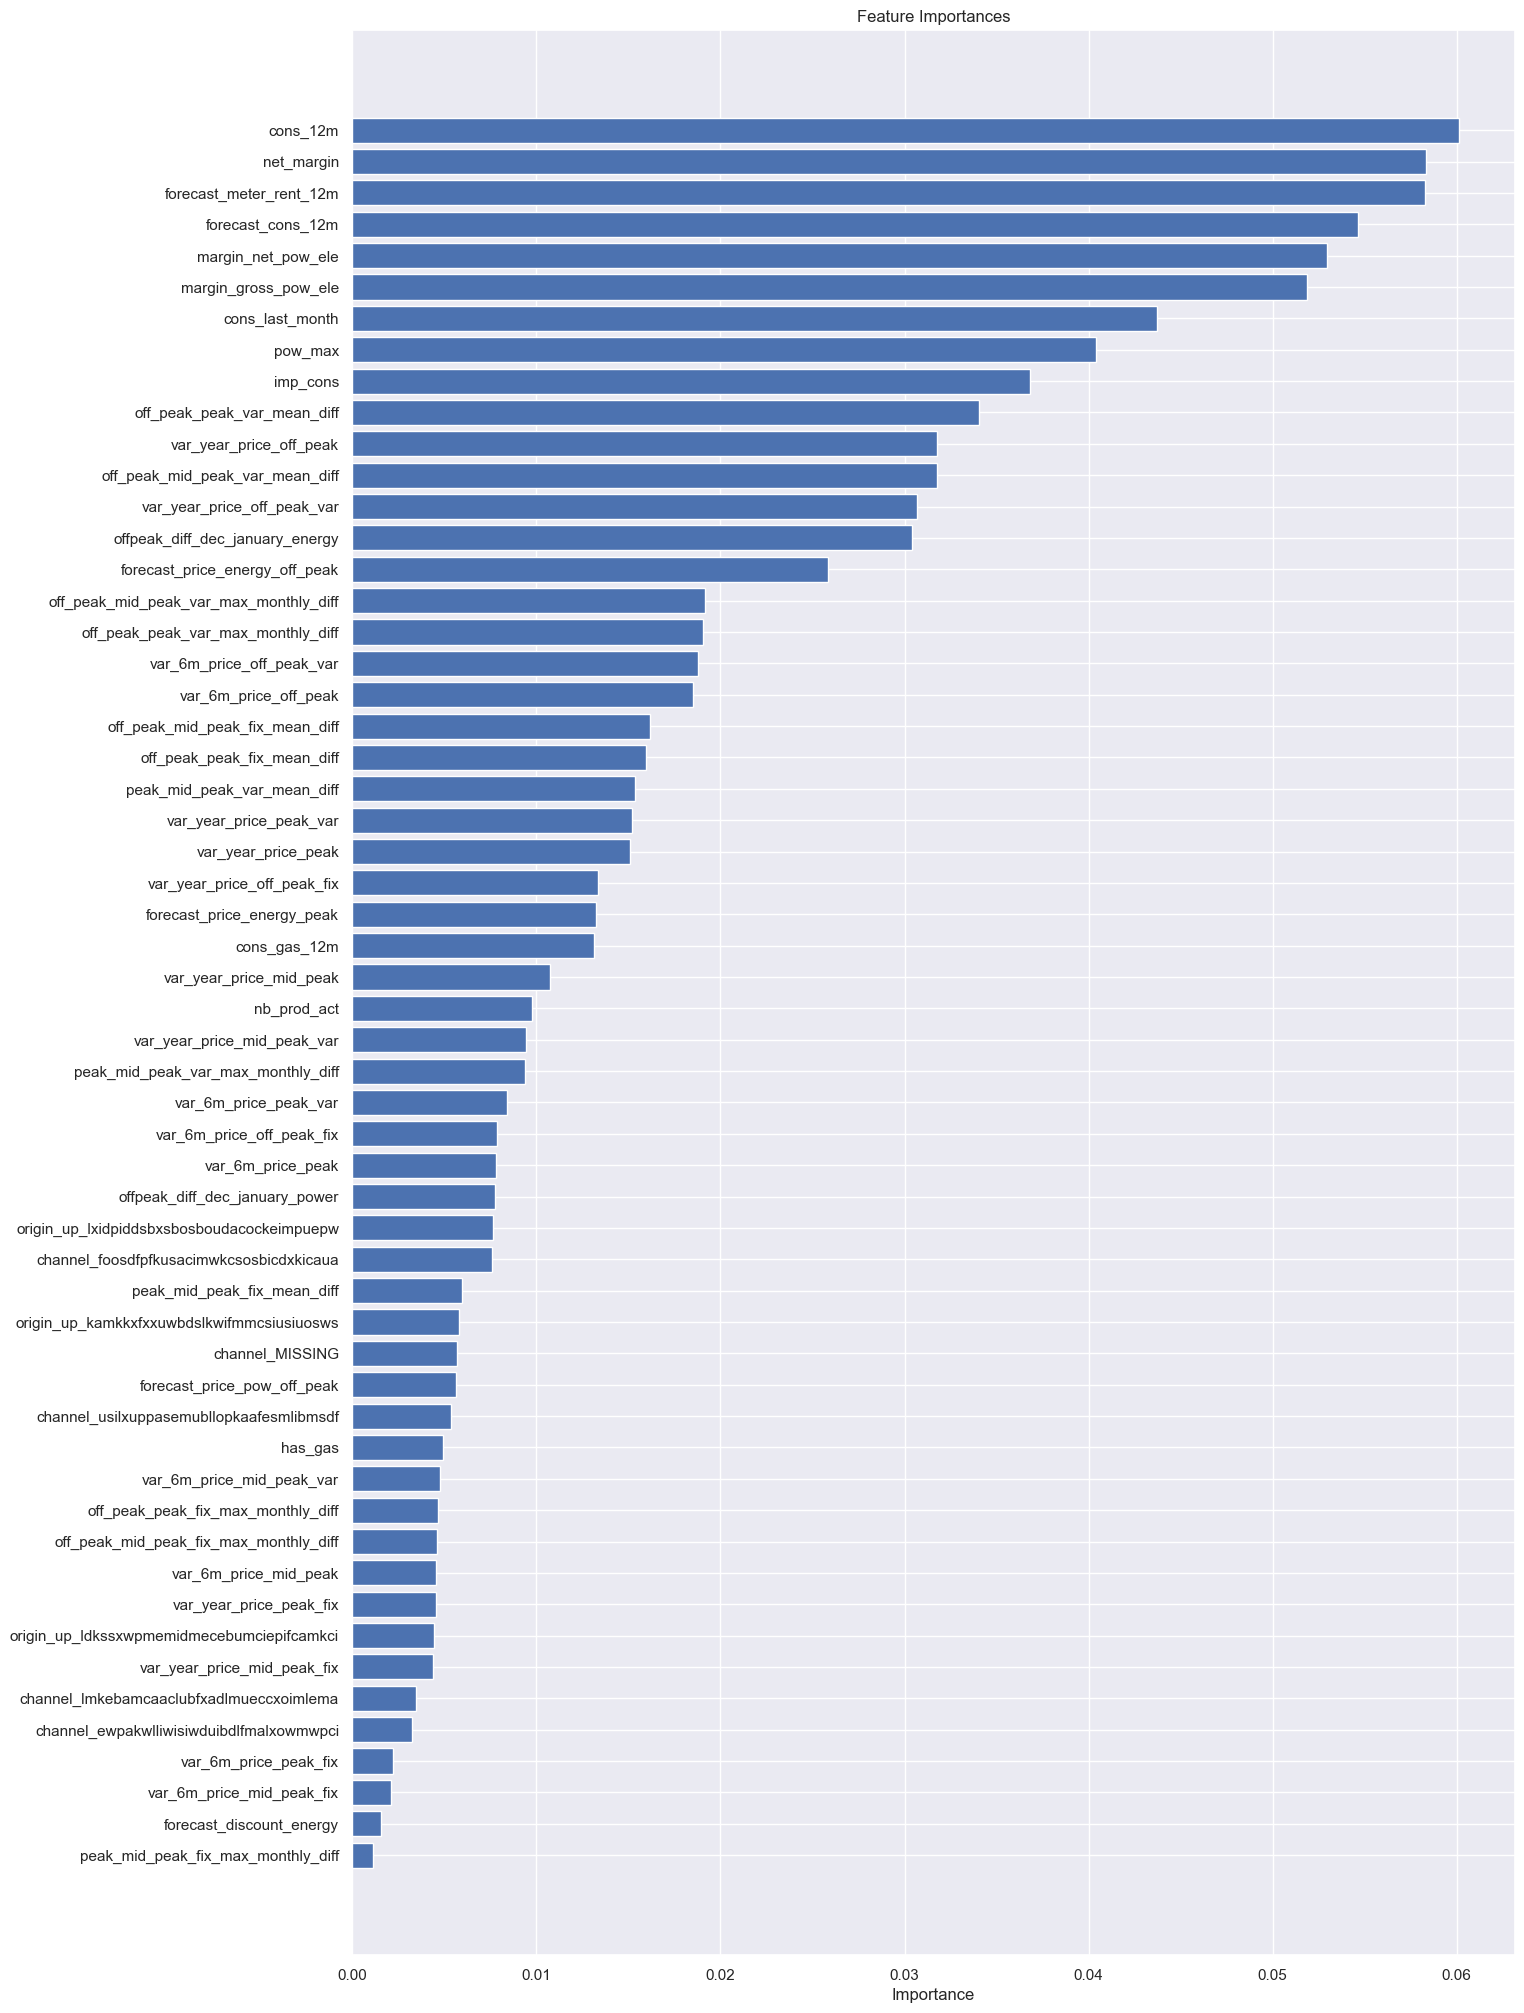

In [38]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [116]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [117]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [118]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')

## Conclusion

The most influential predictors of churn include past energy consumption (`cons_12m`), predicted meter rental costs (`forecast_meter_rent_12m`), and the company's net margin from customers (`net_margin`), highlighting the importance of pricing, cost transparency, and customer profitability in retention efforts.

This suggests that customers' past consumption behavior, expected meter rental costs, and the company's net margin from those customers play a significant role in their decision to churn. Other important features include variables related to energy prices, consumption patterns, and contract details.

In [124]:
X_test[['churn','churn_probability']].head()

,churn,churn_probability
0,0,0.117
1,0,0.077
2,0,0.029
3,0,0.178
4,0,0.074
